# ProstMorph
MRI/US fusion using VoxelMorph

In [2]:
from pathlib import Path

import neurite as ne
import numpy as np
import tensorflow as tf
import voxelmorph as vxm

from notebooks.utils import SmartDataGenerator

tf.div_no_nan = tf.math.divide_no_nan

### Build model
Set up the VoxelMorph network

In [3]:
def prepare_model(inshape, lambda_param=0.05, gamma_param=0.01):
    enc_nf = [16, 32, 32, 32]
    dec_nf = [32, 32, 32, 32, 32, 16, 16]

    vxm_model = vxm.networks.VxmDenseSemiSupervisedSeg(
        inshape=inshape, nb_labels=1,
        nb_unet_features=[enc_nf, dec_nf],
        seg_downsize=2
    )

    # assigning loss
    bin_centers = np.linspace(0, 1, 32)  # histogram bins, assume normalized images
    loss_mi = vxm.losses.NMI(bin_centers=bin_centers, vol_size=inshape).loss
    loss_dice = vxm.losses.Dice().loss
    losses = [loss_mi, vxm.losses.Grad('l2').loss, loss_dice]
    loss_weights = [1, lambda_param, gamma_param]

    # assigning metrics
    def mi(y_true, y_pred):
        return -loss_mi(y_true, y_pred)
    def dice(y_true, y_pred):
        return -loss_dice(y_true, y_pred)
    metrics = {'transformer': [mi],
               'seg_transformer': [dice]}

    vxm_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=losses, loss_weights=loss_weights,
        metrics=metrics
    )
    return vxm_model

Create dataset generators

In [4]:
train_test_split = 0.95
train_val_split = 0.90
base_folder = Path(r"C:\Users\ML\Desktop\seba_preprocessed_fusion\numpy_160")
size = (160, 160, 160)

In [5]:
full_data = np.array(list(base_folder.iterdir()))
np.random.shuffle(full_data)
idx = (np.array([train_test_split * train_val_split, train_test_split]) * full_data.shape[0]).astype(int)
train_data, validation_data, test_data = np.split(full_data, idx)
del idx

train_generator = SmartDataGenerator(train_data, dim=size, batch_size=1)
validation_generator = SmartDataGenerator(validation_data, dim=size, batch_size=1)
test_generator = SmartDataGenerator(test_data, dim=size, batch_size=1)

Instantiate network

In [6]:
hyper = {
    'lambda_param': 0.5,
    'gamma_param': 1.0
}

In [7]:
tf.keras.backend.clear_session()
model = prepare_model(inshape=size, lambda_param=hyper['lambda_param'], gamma_param=hyper['gamma_param'])

Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


vxm info: mutual information loss is experimental


In [ ]:
model.summary(line_length=160)
model.outputs

### Train network

In [8]:
config = {
    "name": f"{hyper['lambda_param']}_{hyper['gamma_param']}",
    "initial_epoch": 0,
    "epochs": 200,
    "steps_per_epoch": 100
}
config["base_dir"] = Path(f"../results/test_{config['name']}")
config["log_dir"] =  str(config["base_dir"] / "logs")
config["history_filepath"] = str(config["base_dir"] / "history.csv")
config["checkpoints_dir"] = config["base_dir"] / "checkpoints"
config["checkpoints_filepath"] = str(config["checkpoints_dir"] / "best_weights_{epoch:04d}.ckpt")

config["base_dir"].mkdir(exist_ok=True)

In [9]:
# Callbacks
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=config['log_dir'], histogram_freq=5, write_graph=True, write_images=True),
    tf.keras.callbacks.CSVLogger(filename=config['history_filepath'], separator=';', append=False),
    tf.keras.callbacks.EarlyStopping(patience=20, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.8, patience=15, min_lr=1e-10, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath=config['checkpoints_filepath'], save_weights_only=True, save_best_only=True, verbose=1)
]

In [ ]:
model.load_weights("simple_checkpoint.ckpt")

In [9]:
hist = model.fit(
    train_generator, validation_data=validation_generator,
    epochs=config['epochs'], steps_per_epoch=config['steps_per_epoch'], initial_epoch=config['initial_epoch'],
    callbacks=callbacks,
    # use_multiprocessing=True, workers=4,
    verbose=2
)

Epoch 1/200
100/100 - 426s - loss: -8.0492e-01 - transformer_loss: -4.0619e-02 - flow_resize_loss: 4.6362e-05 - seg_transformer_loss: -7.6433e-01 - transformer_mi: 0.0406 - seg_transformer_dice: 0.7643 - val_loss: -8.0744e-01 - val_transformer_loss: -3.9767e-02 - val_flow_resize_loss: 2.3134e-04 - val_seg_transformer_loss: -7.6779e-01 - val_transformer_mi: 0.0398 - val_seg_transformer_dice: 0.7678

Epoch 00001: val_loss improved from inf to -0.80744, saving model to ..\results\test_0.5_1.0\checkpoints\best_weights_0001.ckpt
Epoch 2/200
100/100 - 363s - loss: -8.1031e-01 - transformer_loss: -4.2495e-02 - flow_resize_loss: 8.2297e-04 - seg_transformer_loss: -7.6822e-01 - transformer_mi: 0.0425 - seg_transformer_dice: 0.7682 - val_loss: -8.1200e-01 - val_transformer_loss: -3.9553e-02 - val_flow_resize_loss: 0.0011 - val_seg_transformer_loss: -7.7298e-01 - val_transformer_mi: 0.0396 - val_seg_transformer_dice: 0.7730

Epoch 00002: val_loss improved from -0.80744 to -0.81200, saving model t

In [11]:
model.save_weights("simple_checkpoint.ckpt")

In [ ]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

# Testing

(just load an input and watch the morphing)

Eventually load the latest checkpoint

In [10]:
latest_checkpoint = tf.train.latest_checkpoint(config["checkpoints_dir"])
model.load_weights(latest_checkpoint)

Evaluate on the test sest

In [13]:
model.evaluate(test_generator, return_dict=True)

96/96 [==============================] - 91s 936ms/step - loss: -0.4699 - transformer_loss: -0.0520 - flow_resize_loss: 0.0064 - seg_transformer_loss: -0.8613 - transformer_mi: 0.0520 - seg_transformer_dice: 0.8613


{'loss': -0.46991097927093506,
 'transformer_loss': -0.05197347328066826,
 'flow_resize_loss': 0.006350518669933081,
 'seg_transformer_loss': -0.8612771034240723,
 'transformer_mi': 0.05197347328066826,
 'seg_transformer_dice': 0.8612771034240723}

In [33]:
test_input, test_output = test_generator[25]
test_pred = model.predict(test_input)
# model.evaluate(test_input, test_output, return_dict=True)

In [34]:
kern = np.array([[[0, 0, 0], [0,  1, 0], [0, 0, 0]],
                 [[0, 1, 0], [1, -6, 1], [0, 1, 0]],
                 [[0, 0, 0], [0,  1, 0], [0, 0, 0]]], dtype=np.float32)
kern = kern[..., np.newaxis, np.newaxis]
sharpen = np.array(tf.keras.backend.conv3d(test_pred[0], kern, padding='same'))

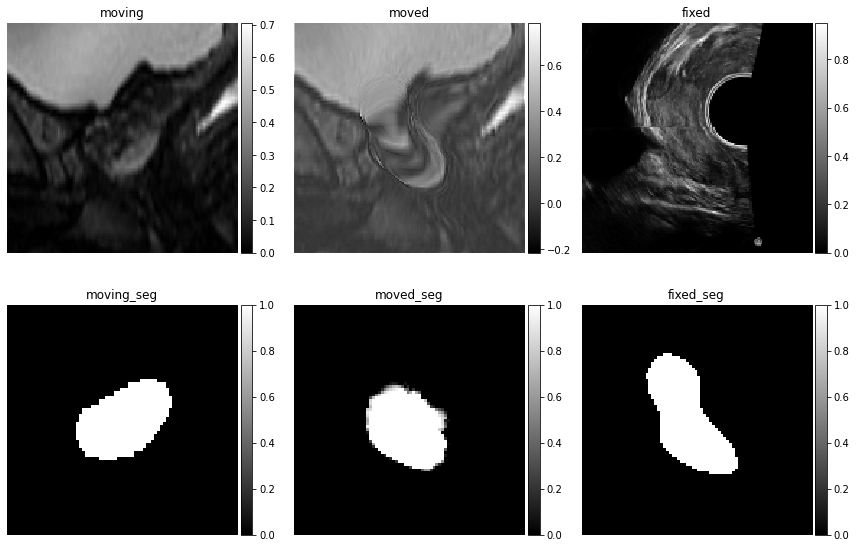

In [35]:
n_slice = 35
images = [img[0, :, :, n_slice * 2].squeeze() for img in [test_input[0], test_pred[0] - 0.5 * sharpen, test_input[1]]]
images += [img[0, :, :, n_slice].squeeze() for img in [test_input[2], test_pred[2], test_output[2]]]
titles = ['moving', 'moved', 'fixed', 'moving_seg', 'moved_seg', 'fixed_seg']
_ = ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, grid=(2, 3), width=12)

In [ ]:
flow = test_pred[1].squeeze()
_ = ne.plot.flow([flow[:, :, i, [0,1]] for i in range(0, 80, 8)], width=25)

In [13]:
import k3d

flow = test_pred[1].squeeze()

plot = k3d.plot()
plot += k3d.factory.vector_field(flow)
plot.display()

Output()